In [1]:
import pandas as pd
import numpy as np
import pdfplumber as scrapper
import PyPDF2
from io import StringIO
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Step 1. Importing all items and products

In [2]:
# Identify all items
item_num = 0
products_list = [] # List to store product names
# item_prod_relations = {} # Dictionary to store relationships between items and products # NOT USED
prod_num_in_items = 0 # Counter for product numbers in items

path = "C:/Users/smvan/CFFS-S23/CFFS-22-23"
os.chdir(path)
filepath = glob.glob(os.path.join(os.getcwd(), "data", "AMS", "*.pdf"))

col_list = ["ItemId", "Description", "Qty", "UOM", "PrepId"]
df = pd.DataFrame(columns=col_list) # Create an empty (df) DataFrame with the col_list elements as the column names
df

for file in filepath:
    
    # Some of the tools I have commented got DeprecationError so I changed them to the latest version

    def generate_items(pdf):
        file = open(str(pdf), "rb") # Open the PDF file in binary read mode
        # pdfReader = PyPDF2.PdfFileReader(file)
        pdfReader = PyPDF2.PdfReader(file) # Create a PDF reader object using the latest version
        # pageObj = pdfReader.getPage(0) 
        pageObj = pdfReader.pages[0]  # Get the first page of the PDF using the latest version
        # myfile = pageObj.extractText()
        myfile = pageObj.extract_text() # Extract text from the PDF page using the latest version

        product = myfile.partition('\n')[0]
        products_list.append(product)      # Add product names in the list
        myfile = myfile.split("\n", 4)[4]
        myfile = myfile.splitlines()
        df = pd.read_csv(StringIO("\n". join(myfile)), sep=" ", names=range(20), on_bad_lines="skip", quotechar=None, quoting=3)

        amounts = df.iloc[:, 0:4]
        amounts_col = ["Single", "Double", "Triple", "Half"]
        amounts.columns = amounts_col
        ingredient = df.iloc[:, 5:]
        ingredient["Description"] = ingredient.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
        ingredient["Description"] = ingredient["Description"].str.replace("nan","")
        ingredient['Description'] = ingredient['Description'].str.extract('(\d*\.*\d*\s*[A-Z].*$)')
        df = pd.concat([amounts, ingredient["Description"]], axis=1)

        df["ItemId"] = ""

        df[["Amount", "Unit"]] = df["Single"].str.extract(pat=r"(\d+\.?\d*)(.*)")
        ind_num = df[df["Amount"].isnull()].index.tolist()
        min_nan = min(ind_num)
        df = df.iloc[:min_nan]
        df["InventoryGroup"] = ""

        global prod_num_in_items

        df["PrepId"] = "P-" + str(prod_num_in_items) # add the product id
        prod_num_in_items += 1                       # increment prod_num_in_items
        df = df.rename(columns={"Amount": "Qty", "Unit":"UOM"})

        for ind, row in df.iterrows():

            global item_num
            df.loc[ind, "ItemId"] = "I-" + str(item_num) # Assign a unique item ID
            item_num += 1

        item_col_list = ["ItemId", "Description", "Qty", "UOM", "PrepId"]
        df = df[item_col_list]

        return df
    
    temp_df = generate_items(file) # Generate items from the file
    global df
    df = pd.concat([df, temp_df], axis=0)  # Concatenate the generated items with the main DataFrame
    
items = df    
print(len(items))
items.head(30)


# My understanding of the code:
# Each recipe ingredients are added onto the dataframe and they are numbered 0 to whatever the number of ingredients there are
# in the recipe and then when we start a new recipe we again start from 0 and go upto the number of items in the recipe

# The items are all listed accordingly to the products .pdf in the AMS data folder. Here the items are all listed starting from 
# the 2022.3 Full Aloo Tikki Burger

154


,ItemId,Description,Qty,UOM,PrepId
0,I-0,BUN Multigrain Vegan 4.5,1.000,ea,P-0
1,I-1,2022.3 Mint Chutney,20.000,g,P-0
2,I-2,Tamarind Chutney 1L,20.000,ml,P-0
3,I-3,Lettuce - Butter,0.050,ea,P-0
4,I-4,ONION RED JUMBO,10.000,g,P-0
5,I-5,TOMATO - 6 X 7 MED,30.000,g,P-0
6,I-6,CUCUMBER LONG ENGLI S,15.000,g,P-0
7,I-7,PATTY PATTY 2022.3 Aloo Tikki,1.000,PATTY,P-0
0,I-8,2022.3 Potato Patty,120.000,g,P-1
1,I-9,Sabutdana,15.000,g,P-1


In [3]:
prep_num = 0

# calculate the product 

def generate_products():
    global products_list # Access the global variable 'products_list'
    columns = ["Description"] # Create a list of column names
    # Create a DataFrame using 'products_list' and column names
    df = pd.DataFrame(products_list, columns=columns) 
    df["PrepId"] = "" # Add an empty column 'PrepId' to the DataFrame
    
    
    for ind, row in df.iterrows(): # Iterate over each row in the DataFrame

        global prep_num
        df.loc[ind, "PrepId"] = "P-" + str(prep_num) # Assign a PrepId to each row using 'prep_num'
        prep_num += 1
    
    df['Description'] = df['Description'].str.replace('^2022.3 ','') # Remove the pattern '^2022.3 ' from the 'Description' column
    df['Description'] = df['Description'].str.replace('\s*FLAVOUR LAB \(FLAVLAB\)','') # Remove the pattern '\s*FLAVOUR LAB \(FLAVLAB\)' from the 'Description' column
    prep_col_list = ["PrepId", "Description"] # Create a list of column names to keep in the final DataFrame
    df = df[prep_col_list] # Select only the columns specified in 'prep_col_list'
    
    return df
    
products = generate_products() # Generate products using the 'generate_products' function
products # Print the generated products DataFrame

,PrepId,Description
0,P-0,Full Aloo Tikki Burger
1,P-1,Aloo Tikki
2,P-2,Confit Garlic Oil
3,P-3,Cooked Bowtie
4,P-4,Double Down Chicken
5,P-5,Fattoush Salad
6,P-6,Fried Chickpea
7,P-7,Full KFC Double Down
8,P-8,Full Smoked Tofu Burger
9,P-9,Gochujang Alfredo


### Step 1-a. Identifying *Pure Items*
**Pure items**: Items that are independent on its own. These items are NOT used as an ingredient for another product. 

In [4]:
# Made some changes below. Since there is no notebooks folder we cannot include it in the path

# pure_df contains items used for only one product.

mask = items["Description"].str.contains('2022.3')
masked = items[mask]

pure_df = pd.merge(items, masked, how='outer', indicator='Exist')

pure_df = pure_df.loc[pure_df['Exist'] != 'both']
pure_df = pure_df.drop(["Exist"], axis=1)
# pure_df.to_csv("notebooks/data/AMS/preprocessed/pure_items.csv", index=False)
pure_df.to_csv("data/AMS/preprocessed/pure_items.csv", index=False)
pure_df

,ItemId,Description,Qty,UOM,PrepId
0,I-0,BUN Multigrain Vegan 4.5,1.000,ea,P-0
2,I-2,Tamarind Chutney 1L,20.000,ml,P-0
3,I-3,Lettuce - Butter,0.050,ea,P-0
4,I-4,ONION RED JUMBO,10.000,g,P-0
5,I-5,TOMATO - 6 X 7 MED,30.000,g,P-0
...,...,...,...,...,...
149,I-149,SALT COARSE KOSHER,10.000,g,P-27
150,I-150,GARLIC WHOLE PEELED,30.000,g,P-27
151,I-151,Juice - Lemon Fresh Sque e,100.000,g,P-27
152,I-152,PFO OIL CANOLA JIB AN T,3000.000,ml,P-28


Filter out **child items** which are used as items for other products. 

In [5]:
# child_items = masked.copy()
# child_items = child_items.reset_index().drop(["index"], axis=1)
# child_items["OriginId"]= ""
# child_items.to_csv("notebooks/data/AMS/preprocessed/Child_parent_df.csv", index=False)

# child_items = pd.read_csv("notebooks/data/AMS/preprocessed/Child_parent_df.csv")
# print(child_items["OriginId"].unique().tolist())
# child_items

- `PrepId`: what that item will be used to make.
- `ProdId`: the made product will be used in future to make another product.

In [5]:
# child_items = child_items.drop("PrepId", axis=1)
# child_items = child_items.rename(columns={"OriginId": "PrepId", "PrepId":"ProdId"})
# child_items.to_csv("notebooks/data/AMS/preprocessed/Child_parent_df.csv", index=False)

# for ind, row in child_items.iterrows():
#     if pd.isnull(child_items.at[ind,'PrepId']) == True:
#         child_items.loc[ind, "PrepId"] = row["ProdId"]
        
# child_items.to_csv("notebooks/data/AMS/preprocessed/Child_parent_df.csv", index=False)

# child_items = pd.read_csv("notebooks/data/AMS/preprocessed/Child_parent_df.csv")


# Made some changes below. Since there is no notebooks folder we cannot include it in the path

child_items = pd.read_csv("data/AMS/preprocessed/Child_parent_df.csv")
child_items

,ItemId,Description,Qty,UOM,ProdId,PrepId
0,I-1,2022.3 Basic Pickling Liqui d,1000.00,g,P-0,P-0
1,I-3,PORT PORT 2022.3 Double Down Chick e,2.00,PORT,P-1,P-20
2,I-4,PATTY PATTY 2022.3 Rice Patty Cake,1.00,PATTY,P-1,P-21
3,I-13,2022.3 Mint Chutney,20.00,g,P-3,P-25
4,I-19,PATTY PATTY 2022.3 Aloo Tikki,1.00,PATTY,P-3,P-18
5,I-47,2022.3 Cooked Penne,10.00,oz,P-9,P-9
6,I-48,2022.3 Marinara,6.00,oz,P-9,P-9
7,I-58,2022.3 Thyme Oil,1000.00,g,P-10,P-27
8,I-81,2022.3 Smoked Paprika Ru,30.00,g,P-15,P-5
9,I-96,2022.3 Potato Patty,120.00,g,P-18,P-12


In [6]:
looped_list = []

for ind, row in child_items.iterrows():
    if row["PrepId"] in ['P-20', 'P-18', 'P-15']:
        looped_list.append(row["ProdId"])

looped_list

['P-1', 'P-3', 'P-24']

In [7]:
parent_prod = ["P-3", "P-1", "P-24", "P-22", "P-13", "P-20"] 

Isolate items that are used for **child products**. 

In [8]:
child_id = child_items.dropna(subset=['PrepId'])
child_list = []

# Identify products that are used as used as ingredients for other products.
for item in child_id["PrepId"].unique().tolist():
    if item in child_items["ProdId"].tolist():
        child_list.append(item)
        
# Identify looped-child products and remove from dataframe. 
col_list = ["ItemId", "Description", "Qty", "UOM", "PrepId"]
new_df = pd.DataFrame(columns=col_list)

for item in child_items["PrepId"].unique().tolist():
    for ind, row in items.iterrows():
        if row["PrepId"] == item:
            new_df = new_df.append(pd.Series(row))

new_df = new_df.reset_index()
drop_df = pd.DataFrame(columns=["ItemId", "Description", "Qty", "UOM", "PrepId"])

# Items used for child products 
for ind, row in new_df.iterrows():
    if row["PrepId"] in child_list:
        new_df = new_df.drop(ind)
        drop_df = drop_df.append(row)
        
new_df = new_df.drop(["index"], axis=1)
print("Removed: ", child_list)
print("Kept: ", new_df["PrepId"].unique().tolist())
new_df

Removed:  ['P-0', 'P-20', 'P-18', 'P-9', 'P-15']
Kept:  ['P-21', 'P-25', 'P-27', 'P-5', 'P-12', 'P-28', 'P-2', 'P-17']


,ItemId,Description,Qty,UOM,PrepId
14,I-118,2022.2 Cooked Sushi Rice,1350.000,g,P-21
15,I-119,SHICHIMI TOGARASHI,15.000,g,P-21
16,I-120,PFO OIL CANOLA JIB AN T,100.000,ml,P-21
17,I-134,Tofu MED Firm Sunrise,36.000,lb,P-25
18,I-135,Hickory Wood Chips,1000.000,g,P-25
19,I-136,SALT COARSE KOSHER,250.000,g,P-25
25,I-147,SPICE SUMAC ground,30.000,g,P-27
26,I-148,Olive Oil Extra virgin,400.000,ml,P-27
27,I-149,SALT COARSE KOSHER,10.000,g,P-27
28,I-150,GARLIC WHOLE PEELED,30.000,g,P-27


In [9]:
for ind, row in drop_df.iterrows():
    if row["PrepId"] in ["P-0", "P-9"]:
        drop_df = drop_df.drop(ind)
        
drop_df
# drop_df.to_csv("notebooks/data/AMS/preprocessed/Looped_child_df.csv", index=False)

,ItemId,Description,Qty,UOM,PrepId,index
8,I-112,POTATO RUSSET BAKER,150.000,g,P-20,0.0
9,I-113,Cheese 3 Blend Shred,50.000,g,P-20,1.0
10,I-114,Bacon Raw 14-22ct econo,2.000,slice,P-20,2.0
11,I-115,CREAM SOUR 4L,30.000,g,P-20,3.0
12,I-116,ONIONS GREEN,5.000,g,P-20,4.0
13,I-117,SPICE CHILI POWDER,1.000,g,P-20,5.0
20,I-101,Radish - Daikon,1000.000,g,P-18,0.0
21,I-102,2022.3 Basic Pickling Liqui d,1000.000,g,P-18,1.0
45,I-90,ONIONS,750.000,g,P-15,0.0
46,I-91,GARLIC WHOLE PEELED,250.000,g,P-15,1.0


In [10]:
# Made some changes below. Since there is no notebooks folder we cannot include it in the path

pure_items = pd.read_csv("data/AMS/preprocessed/Pure_items_labelled.csv")
# pure_items = pd.read_csv("notebooks/data/AMS/preprocessed/Pure_items_labelled.csv")

# Filter out complicated items
for ind, row in pure_items.iterrows():
    if row["ProdId"] in parent_prod:
        pure_items = pure_items.drop(ind)

In [11]:
pure_items

,ProdId,Weight (g),Total CO2 Emission (g),Total Nitrogen Emission (g),Total Freshwater Withdrawals (mL),GHG Emission (g) / 100g,N lost (g) / 100g,Stress-Weighted Water Use (L) / 100g,GHG Emission (g) / g,N lost (g) / g,Stress-Weighted Water Use (L) / g
0,P-5,1208.400,127.33515,2.386590,14865.9900,10.537500,0.197500,1.230221,0.105375,0.001975,0.012302
1,P-17,3783.000,824.83414,3.127140,38171.5800,21.803704,0.082663,1.009029,0.218037,0.000827,0.010090
2,P-21,570.000,71.83600,1.371250,11531.6250,12.602807,0.240570,2.023092,0.126028,0.002406,0.020231
3,P-12,121176.000,26251.48920,119.366000,225042.1000,21.663934,0.098506,0.185715,0.216639,0.000985,0.001857
4,P-2,74317.248,38522.17911,108.092941,135273.4592,51.834776,0.145448,0.182022,0.518348,0.001454,0.001820


---

## Step 2. Merge Dataframes

In [12]:
pure_items = pd.read_csv("data/AMS/preprocessed/Labelled_per_Items.csv")
# pure_items = pure_items.drop(["Weight (g)", "Total CO2 Emission (g)", "Total Nitrogen Emission (g)", 
#                               "Total Freshwater Withdrawals (mL)"], axis=1)
pure_items = pure_items.drop("Weight (g)", axis=1)
pure_items = pure_items.rename(columns={"ConvertToQty":"Weight (g)"})
# pure_items = pure_items.rename(columns={"ConvertToQty":"Weight (g)",
#                                        "CO2 Emission (g CO2)": "Total CO2 Emission (g)",
#                                        "Nitrogen Lost (g)": "Total Nitrogen Emission (g)",
#                                        "Water Withdrawals (mL)": "Total Freshwater Withdrawals (mL)"})
pure_items = pure_items[["ConversionId", "PrepId", "Weight (g)", "GHG Emission (g) / 100g", "N lost (g) / 100g", 
                         "Stress-Weighted Water Use (L) / 100g", "Total CO2 Emission (g)", "Total Nitrogen Emission (g)",
                         "Total Freshwater Withdrawals (mL)"]]
pure_items

,ConversionId,PrepId,Weight (g),GHG Emission (g) / 100g,N lost (g) / 100g,Stress-Weighted Water Use (L) / 100g,Total CO2 Emission (g),Total Nitrogen Emission (g),Total Freshwater Withdrawals (mL)
0,I-0,P-0,1000.00,30.620000,0.790000,0.990000,306.200000,7.900000,9900.000
1,I-2,P-1,1.00,0.000000,0.000000,0.000943,0.000000,0.000000,1.000
2,I-77,P-14,5000.00,0.000000,0.000000,0.070126,0.000000,0.000000,5000.000
3,I-95,P-17,100.00,0.000000,0.000000,0.017544,0.000000,0.000000,100.000
4,I-6,P-1,30.00,19.618868,0.223585,2.179245,20.796000,0.237000,2310.000
...,...,...,...,...,...,...,...,...,...
132,I-22,P-4,35.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
133,I-50,P-9,1.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
134,I-74,P-13,1.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
135,I-43,P-8,24.00,90.752308,1.225846,16.710462,235.956000,3.187200,43447.200


In [14]:
child_prods = pd.read_csv("data/AMS/preprocessed/Labelled_per_Child_Items.csv")
child_prods["ConversionId"] = child_prods["ProdId"]
child_items = child_prods[["ConversionId", "PrepId", "Weight (g)", "GHG Emission (g) / 100g", "N lost (g) / 100g", 
                           "Stress-Weighted Water Use (L) / 100g", "Land Use (m^2) / g", "Total CO2 Emission (g)", "Total Nitrogen Emission (g)",
                           "Total Freshwater Withdrawals (mL)", "Total Land Use (m^2)"]]
child_items

,ConversionId,PrepId,Weight (g),GHG Emission (g) / 100g,N lost (g) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / g,Total CO2 Emission (g),Total Nitrogen Emission (g),Total Freshwater Withdrawals (mL),Total Land Use (m^2)
0,P-0,P-0,1000.000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,1.000000e+03,0.000000
1,P-9,P-9,907.184,47.578125,0.589063,13.479219,0.001528,431.621137,5.343881,1.222813e+05,1.386291
2,P-17,P-24,300.000,0.000000,0.675000,2.022500,0.000000,0.000000,2.025000,6.067500e+03,0.000000
3,P-2,P-22,17579.300,175.420000,0.590000,0.660000,0.004140,30837.608060,103.717870,1.160234e+05,72.778302
4,P-5,P-15,30.000,937.030000,0.675000,2.490000,0.031000,281.109000,0.202500,7.470000e+02,0.930000
5,P-25,P-3,20.000,50.290000,0.790000,8.130000,0.001190,10.058000,0.158000,1.626000e+03,0.023800
6,P-18,P-3,135.000,39.700000,0.500000,0.260000,0.000520,53.595000,0.675000,3.510000e+02,0.070200
7,P-12,P-18,120.000,39.700000,0.500000,0.260000,0.000520,47.640000,0.600000,3.120000e+02,0.062400
8,P-21,P-22,3470.000,126.725000,0.265000,78.745000,0.001085,4397.357500,9.195500,2.732452e+06,3.764950
9,P-20,P-1,4735.920,439.960000,11.680000,37.030000,0.011510,20836.153632,553.155456,1.753711e+06,54.510439


In [18]:
df = pd.concat([pure_items, child_items], axis = 0)
df

,ConversionId,PrepId,Weight (g),GHG Emission (g) / 100g,N lost (g) / 100g,Stress-Weighted Water Use (L) / 100g,Total CO2 Emission (g),Total Nitrogen Emission (g),Total Freshwater Withdrawals (mL),Land Use (m^2) / g,Total Land Use (m^2)
0,I-0,P-0,1000.00,30.620000,0.790000,0.990000,306.200000,7.900000,9900.000,NaN,NaN
1,I-2,P-1,1.00,0.000000,0.000000,0.000943,0.000000,0.000000,1.000,NaN,NaN
2,I-77,P-14,5000.00,0.000000,0.000000,0.070126,0.000000,0.000000,5000.000,NaN,NaN
3,I-95,P-17,100.00,0.000000,0.000000,0.017544,0.000000,0.000000,100.000,NaN,NaN
4,I-6,P-1,30.00,19.618868,0.223585,2.179245,20.796000,0.237000,2310.000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
8,P-21,P-22,3470.00,126.725000,0.265000,78.745000,4397.357500,9.195500,2732451.500,0.001085,3.764950
9,P-20,P-1,4735.92,439.960000,11.680000,37.030000,20836.153632,553.155456,1753711.176,0.011510,54.510439
10,P-28,P-26,18143.68,219.980000,5.840000,18.515000,39912.467264,1059.590912,3359302.352,0.005755,104.416878
11,P-27,P-10,1000.00,315.090000,0.020000,6.750000,3150.900000,0.200000,67500.000,0.013140,13.140000


In [33]:
# final_df = pd.DataFrame(columns=["ProdId", "Weight (g)", "Total CO2 Emission (g)", "Total Nitrogen Emission (g)",
#                                  "Total Freshwater Withdrawals (mL)"])

final_df = pd.DataFrame(columns=["ProdId", "Weight (g)", "Total CO2 Emission (g)", "Total Nitrogen Emission (g)",
                                 "Total Freshwater Withdrawals (mL)", "Total Land Use (m^2)"])

df = pd.read_csv("data/AMS/preprocessed/processed_items.csv")

all_prod = df["PrepId"].unique().tolist()

for prod in all_prod:
    temp_df = df.loc[df["PrepId"] == prod]
    # Here we make the prepId = product id
    ProdId = prod
    Weight = 0
    total_CO2 = 0
    total_N = 0
    total_Water = 0
    
    total_Land = 0
    for ind, row in temp_df.iterrows(): 
        Weight += row["Weight (g)"]
        total_CO2 += row["Total CO2 Emission (g)"]
        total_N += row["Total Nitrogen Emission (g)"]
        total_Water += row["Total Freshwater Withdrawals (mL)"]
        
        # May 30
        total_Land += row["Total Land Use (m^2)"]
        
    info = [ProdId, Weight, total_CO2, total_N, total_Water, total_Land]
    
    # See what line below is doing
    final_df.loc[len(final_df.index)] = info
    # final_df = info
    
    
final_df

# print(final_df["ProdId"].unique())
# a = pd.read_csv("data/AMS/preprocessed/unprocessed_items.csv")
# print(a["PrepId"].unique())

,ProdId,Weight (g),Total CO2 Emission (g),Total Nitrogen Emission (g),Total Freshwater Withdrawals (mL),Total Land Use (m^2)
0,P-0,4000.0000,306.200000,7.900000,1.090000e+04,0.320000
1,P-1,44148.4400,24583.994632,561.619706,4.065433e+06,57.722789
2,P-14,28520.0000,3258.149000,29.606000,8.529370e+05,10.581300
3,P-17,2850.0000,2549.874000,0.519500,1.280640e+05,11.629900
4,P-3,4680.0000,611.573000,6.356500,1.472910e+05,1.777350
5,P-24,22095.0000,1109.409500,15.009500,1.013190e+05,2.997450
6,P-7,28604.5265,4804.217219,19.285610,3.514520e+04,12.809625
7,P-4,44277.0000,83788.800000,355.347000,3.920529e+05,93.600000
8,P-12,33880.5000,1861.777250,19.131250,1.402925e+05,3.651775
9,P-13,9903.0000,20947.200000,86.265000,9.030750e+04,23.400000


In [35]:
# DONE THIS IN THE AMS MAPPING STEP

def calculate_100g_emissions(df):
    for ind, row in df.iterrows():
        df.loc[ind, "GHG Emission (g) / 100g"] = (row["Total CO2 Emission (g)"] / row["Weight (g)"]) * 100
        df.loc[ind, "N lost (g) / 100g"] = (row["Total Nitrogen Emission (g)"] / row["Weight (g)"]) * 100
        df.loc[ind, "Stress-Weighted Water Use (L) / 100g"] = ((row["Total Freshwater Withdrawals (mL)"] / 1000) / row["Weight (g)"]) * 100
        
        # Added May 29
        df.loc[ind, "Land Use (m^2) / 100g"] = (row["Total Land Use (m^2)"] / row["Weight (g)"]) * 100
    print(df.columns)
    return df

# def calculate_100g_emissions(df):
#     for ind, row in df.iterrows():
#         df.loc[ind, "GHG Emission (g) / 100g"] = (row["Total CO2 Emission (g)"] / row["Weight (g)"]) * 100
#         df.loc[ind, "N lost (g) / 100g"] = (row["Total Nitrogen Emission (g)"] / row["Weight (g)"]) * 100
#         df.loc[ind, "Stress-Weighted Water Use (L) / 100g"] = ((row["Total Freshwater Withdrawals (mL)"] / 1000) / row["Weight (g)"]) * 100
        
#         # May 30
        
#     return df

calculate_100g_emissions(final_df)


Index(['ProdId', 'Weight (g)', 'Total CO2 Emission (g)',
       'Total Nitrogen Emission (g)', 'Total Freshwater Withdrawals (mL)',
       'Total Land Use (m^2)', 'Combined Label', 'GHG Emission (g) / 100g',
       'N lost (g) / 100g', 'Stress-Weighted Water Use (L) / 100g',
       'Land Use (m^2) / 100g'],
      dtype='object')


,ProdId,Weight (g),Total CO2 Emission (g),Total Nitrogen Emission (g),Total Freshwater Withdrawals (mL),Total Land Use (m^2),Combined Label,GHG Emission (g) / 100g,N lost (g) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g
0,P-0,4000.0000,306.200000,7.900000,1.090000e+04,0.320000,,7.655000,0.197500,0.272500,0.008000
1,P-1,44148.4400,24583.994632,561.619706,4.065433e+06,57.722789,,55.684855,1.272117,9.208554,0.130747
2,P-14,28520.0000,3258.149000,29.606000,8.529370e+05,10.581300,,11.424085,0.103808,2.990663,0.037101
3,P-17,2850.0000,2549.874000,0.519500,1.280640e+05,11.629900,,89.469263,0.018228,4.493474,0.408067
4,P-3,4680.0000,611.573000,6.356500,1.472910e+05,1.777350,,13.067799,0.135823,3.147244,0.037978
5,P-24,22095.0000,1109.409500,15.009500,1.013190e+05,2.997450,,5.021088,0.067932,0.458561,0.013566
6,P-7,28604.5265,4804.217219,19.285610,3.514520e+04,12.809625,,16.795304,0.067422,0.122866,0.044782
7,P-4,44277.0000,83788.800000,355.347000,3.920529e+05,93.600000,,189.237753,0.802554,0.885455,0.211396
8,P-12,33880.5000,1861.777250,19.131250,1.402925e+05,3.651775,,5.495129,0.056467,0.414080,0.010778
9,P-13,9903.0000,20947.200000,86.265000,9.030750e+04,23.400000,,211.523781,0.871100,0.911921,0.236292


In [42]:
# Adjusted baselines May 30:
fifty_cutoff = 191.12
# is the overall baseline supposed to be the GHG_baseline?
overall_baseline = 382.25

GHG_baseline = 382.25
nitrogen_baseline = 3.86
water_baseline = 1248.19
land_baseline = 934.29
# land_baseline = 321.29

# ORIGINAL
# fifty_cutoff = 180.12
# overall_baseline = 360.25

# GHG_baseline = 381.13
# nitrogen_baseline = 4.21
# water_baseline = 1501.2

def create_results_all_factors(df):
    df["Combined Label"] = ""

    def calculate_all_factors(ghg, nitrogen, water, land):
        weighted_ghg = ghg / (GHG_baseline)
        weighted_nitrogen = nitrogen / (nitrogen_baseline)
        weighted_water = water / (water_baseline)

        # most recently added
        weighted_land = land / (land_baseline)

        return weighted_ghg + weighted_nitrogen + weighted_water + weighted_land
    
    
          # original one with dividing by 4
        
#         weighted_ghg = ghg / (GHG_baseline)
#         weighted_nitrogen = nitrogen / (nitrogen_baseline)
#         weighted_water = water / (water_baseline)

#         # most recently added
#         weighted_land = land / (land_baseline)

#         return weighted_ghg + weighted_nitrogen + weighted_water + weighted_land
    
    
    # HERE IS WHERE THE ghg, nitrogen, water, land values are set
    for ind, row in df.iterrows():
        label = calculate_all_factors(row["GHG Emission (g) / 100g"], row["N lost (g) / 100g"],
                                      row["Stress-Weighted Water Use (L) / 100g"], row["Land Use (m^2) / 100g"])
        
        # WHY DO WE COMPARE WITH 0.5, 1

        if label <= 0.5:
            df.loc[ind, "Combined Label"] = "Green"
        elif label >= 1:
            df.loc[ind, "Combined Label"] = "Red"
        elif (label > 0.5) and (label < 1):
            df.loc[ind, "Combined Label"] = "Yellow"
    return df


# ORIGINAL WORK BELOW:

# def create_results_all_factors(df):
#     df["Combined Label"] = ""

#     def calculate_all_factors(ghg, nitrogen, water):
#         weighted_ghg = ghg / (3 * GHG_baseline)
#         weighted_nitrogen = nitrogen / (3 * nitrogen_baseline)
#         weighted_water = water / (3 * water_baseline)
#         return weighted_ghg + weighted_nitrogen + weighted_water

#     for ind, row in df.iterrows():
#         label = calculate_all_factors(row["GHG Emission (g) / 100g"], row["N lost (g) / 100g"],
#                                       row["Stress-Weighted Water Use (L) / 100g"])

#         if label <= 0.5:
#             df.loc[ind, "Combined Label"] = "Green"
#         elif label >= 1:
#             df.loc[ind, "Combined Label"] = "Red"
#         elif (label > 0.5) and (label < 1):
#             df.loc[ind, "Combined Label"] = "Yellow"
#     return df

df = create_results_all_factors(final_df)
print(len(df))
df


29


,ProdId,Weight (g),Total CO2 Emission (g),Total Nitrogen Emission (g),Total Freshwater Withdrawals (mL),Total Land Use (m^2),Combined Label,GHG Emission (g) / 100g,N lost (g) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g
0,P-0,4000.0000,306.200000,7.900000,1.090000e+04,0.320000,Green,7.655000,0.197500,0.272500,0.008000
1,P-1,44148.4400,24583.994632,561.619706,4.065433e+06,57.722789,Green,55.684855,1.272117,9.208554,0.130747
2,P-14,28520.0000,3258.149000,29.606000,8.529370e+05,10.581300,Green,11.424085,0.103808,2.990663,0.037101
3,P-17,2850.0000,2549.874000,0.519500,1.280640e+05,11.629900,Green,89.469263,0.018228,4.493474,0.408067
4,P-3,4680.0000,611.573000,6.356500,1.472910e+05,1.777350,Green,13.067799,0.135823,3.147244,0.037978
5,P-24,22095.0000,1109.409500,15.009500,1.013190e+05,2.997450,Green,5.021088,0.067932,0.458561,0.013566
6,P-7,28604.5265,4804.217219,19.285610,3.514520e+04,12.809625,Green,16.795304,0.067422,0.122866,0.044782
7,P-4,44277.0000,83788.800000,355.347000,3.920529e+05,93.600000,Yellow,189.237753,0.802554,0.885455,0.211396
8,P-12,33880.5000,1861.777250,19.131250,1.402925e+05,3.651775,Green,5.495129,0.056467,0.414080,0.010778
9,P-13,9903.0000,20947.200000,86.265000,9.030750e+04,23.400000,Yellow,211.523781,0.871100,0.911921,0.236292


In [43]:
# ASK WHY ARE WE DROPPING MENU ITEMS HERE??

# looped_menus = ['P-20', 'P-18', 'P-15']
# prod_list = ['P-1', 'P-3', 'P-24']

# # this is a for loop for rows and we are also using the index (ind)
# # So we are dropping menu items: looped_menus from the dataframe. WHY???

# for ind, row in df.iterrows():
#     if row["ProdId"] in looped_menus:
#         df = df.drop(ind)
        
# df

In [44]:
df = df.merge(products, left_on="ProdId", right_on="PrepId")
df = df.drop("PrepId", axis=1)
df_labelled = df[["ProdId", "GHG Emission (g) / 100g", "N lost (g) / 100g", "Stress-Weighted Water Use (L) / 100g",
                  "Land Use (m^2) / 100g", "Combined Label", "Description"]]
df_labelled.to_csv("data/AMS/final/Flavour_Lab_Labelled.csv", index=False)


# The csv file is loading properly but not the Excel file

df_labelled.to_excel("data/AMS/final/Flavour_Lab_Labelled.xlsx")  
df_labelled

,ProdId,GHG Emission (g) / 100g,N lost (g) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,Combined Label,Description
0,P-0,7.655000,0.197500,0.272500,0.008000,Green,Full Aloo Tikki Burger
1,P-1,55.684855,1.272117,9.208554,0.130747,Green,Aloo Tikki
2,P-14,11.424085,0.103808,2.990663,0.037101,Green,Mixed Mushroom
3,P-17,89.469263,0.018228,4.493474,0.408067,Green,Pesto Cream
4,P-3,13.067799,0.135823,3.147244,0.037978,Green,Cooked Bowtie
5,P-24,5.021088,0.067932,0.458561,0.013566,Green,Smoked Paprika Rub
6,P-7,16.795304,0.067422,0.122866,0.044782,Green,Full KFC Double Down
7,P-4,189.237753,0.802554,0.885455,0.211396,Yellow,Double Down Chicken
8,P-12,5.495129,0.056467,0.414080,0.010778,Green,Marinated Chicken Thigh
9,P-13,211.523781,0.871100,0.911921,0.236292,Yellow,Mint Chutney


---
## Step 3. Summary and Visualizations

In [45]:
# changed the dataframe labelling so that Combined Label becomes Combined_Label
df_labelled = df_labelled.rename(columns={"Combined Label": "Combined_Label"})
display(df_labelled.Combined_Label.value_counts())

Green     23
Yellow     3
Red        3
Name: Combined_Label, dtype: int64

In [46]:
df_summary = df_labelled["Combined_Label"].value_counts().to_frame("Label Counts")
df_summary["Percentage"] = (df_summary["Label Counts"] / df_summary["Label Counts"].sum()) * 100
df_summary

,Label Counts,Percentage
Green,23,79.310345
Yellow,3,10.344828
Red,3,10.344828


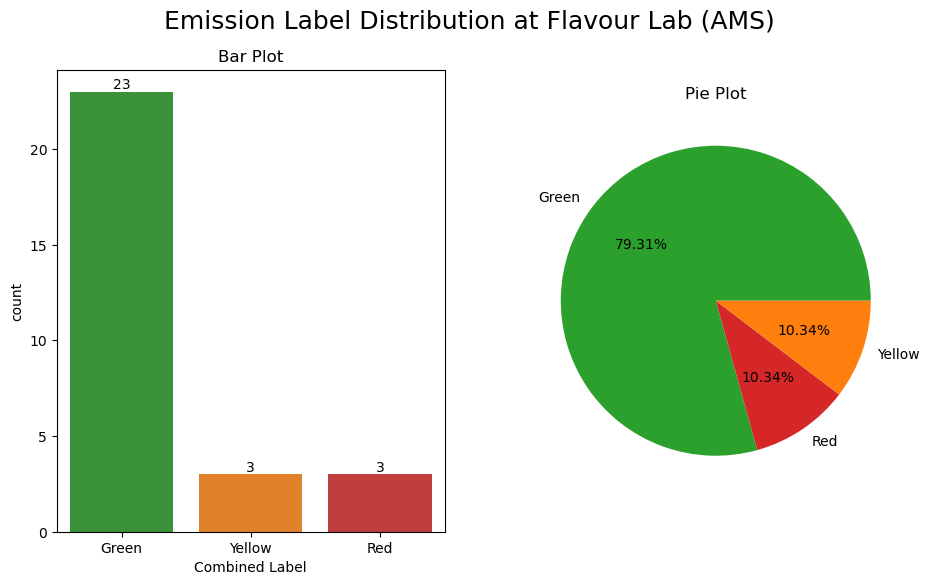

In [47]:
fig, axes = plt.subplots(1,2, figsize=(11,6), sharey=False)

palette = {"Green":"tab:green", "Red":"tab:red", "Yellow":"tab:orange"}
labels = ["Green", "Red", "Yellow"]

# Barplot on the right side
ax1 = sns.countplot(data=df_labelled, x="Combined_Label", ax=axes[0], palette=palette)
ax1.set_xlabel("Combined Label")
ax1.set_title("Bar Plot")

axes[1] = plt.pie(df_labelled["Combined_Label"].value_counts(), 
                  labels=labels,
                  colors=[palette[key] for key in labels],
                  autopct='%1.2f%%',
                  shadow=False)
plt.title("Pie Plot")

for ax in [ax1]:
    for i in ax.containers:
        ax.bar_label(i)

fig.suptitle("Emission Label Distribution at Flavour Lab (AMS)", fontsize=18)
plt.show()